**Task 0: Import libraries**

Utilizza la libreria "google.colab" per montare Google Drive nella directory "/content/drive".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installa la libreria pytorch-lightning

In [ ]:
!pip install pytorch-lightning

Importa diverse librerie utilizzate in Machine Learning. Matplotlib per la visualizzazione, Numpy per operazioni matematiche, PyTorch Lightning per la definizione della rete neurale e l'addestramento, DataLoader e torchvision per la gestione dei dati, e Torchmetrics per il monitoraggio delle metriche, in questo caso, la precisione di classificazione.

In [ ]:
# Matplotlib for plotting, numpy for math operations
from matplotlib import pyplot as plt
import numpy as np

# PyTorch Lightning ⚡ to define our neural network
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

# Dataloader and torchvision to define our input dataset
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import LFWPeople
from torchvision import transforms

# Torchmetrics to monitor metrics (classification accuracy)
from torchmetrics.functional.classification.accuracy import accuracy


**Task 1: Define parameters and hyperparameters**
- Learning rate - how fast does our network learn? (Warning, do not set too high)
- Batch size - how many samples does the network "see" at every iteration (usually, the bigger the better)
- Dataset size - how many samples are in the whole dataset? (train + validation)
- Train size - how many samples are in the training dataset?
- Val size - how many samples are in the validation dataset?
- Input width - how wide (in pixels) is our input image? (must be square images)
- Input height - how tall (in pixels) is our input image? (must be square images)
- Input channels - how many channels does the input image have?
- Mean - dataset mean
- Std - dataset standard variance
- Hidden dim - how many neurons are there in the hidden layer?
- Num classes - how many classes (digits) do we want to classify in our dataset?

In [ ]:
learning_rate = 0.001
batch_size = 64

dataset_size = 1348
train_size = 1001
val_size = 347

dataset_train = 1078
dataset_val = 135
dataset_test = 135
input_width = 224
input_height = 224 #sono uguali poichè la foto ha dimensione quadrata
input_channels = 3 #valore ideale per immagini RGB
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

num_classes = 8

assert train_size + val_size == dataset_size, 'Oh no, the sum of the train and validation sets must be equal the whole dataset size!'
assert input_width == input_height, "Oh no! The input width should be the same as the input height!"

**Task 2: Define the DataModule**

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import LFWPeople
from torchvision import transforms
from collections import Counter
from torchvision.transforms import InterpolationMode
import pytorch_lightning as pl

# Custom Dataset that maps a given dataset to new targets.
class RemappedSubset(Dataset):
    def __init__(self, original_dataset, remapped_targets):
        """
        Initializes the subset dataset with remapped targets.

        :param original_dataset: The original dataset.
        :param remapped_targets: A list of targets that have been remapped.
        """
        self.original_dataset = original_dataset
        self.remapped_targets = remapped_targets

    def __len__(self):
        # Returns the number of items in the dataset.
        return len(self.remapped_targets)

    def __getitem__(self, index):
        """
        Retrieves an item by index.

        :param index: The index of the desired item.
        :return: A tuple of the image and its remapped target.
        """
        img, _ = self.original_dataset[index]
        target = self.remapped_targets[index]
        return img, target

# Data module for handling the LFWPeople dataset.
class MyCustomDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./", image_size=(224, 224), interpolation=InterpolationMode.BILINEAR):
        """
        Initializes the data module.

        :param data_dir: Directory where the data is located.
        :param image_size: The size to which the images will be resized.
        :param interpolation: The interpolation mode to use for resizing.
        """
        super().__init__()
        self.data_dir = data_dir
        # Define the transformations applied to each data item.
        self.transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=interpolation),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def prepare_data(self):
        # Here you can download the data if it's not already present locally.
        # This method is called only from a single GPU.
        pass

    def setup(self, stage=None):
        """
        Sets up the dataset for use in training, validation, and testing.

        :param stage: Defines the stage - fit or test.
        """
        # Load the full LFWPeople dataset with transformations applied.
        dataset = LFWPeople(root=self.data_dir, download=True, transform=self.transform)
        targets = dataset.targets
        # Count the frequency of each class.
        class_freqs = Counter(targets)
        # Sort classes by frequency and select the top 8.
        sorted_classes = sorted(class_freqs.items(), key=lambda x: x[1], reverse=True)
        top_8_classes = [x[0] for x in sorted_classes[:8]]

        # Remap class indices to a new range.
        remapped_targets = {original: remapped for remapped, original in enumerate(top_8_classes)}
        # Filter out the targets that are in the top 8 classes.
        filtered_targets = [remapped_targets[target] for target in targets if target in top_8_classes]
        # Likewise, filter out the indices.
        filtered_indices = [i for i, target in enumerate(targets) if target in top_8_classes]

        # Create a new dataset from the subset of the original data.
        original_subset = torch.utils.data.Subset(dataset, filtered_indices)
        remapped_dataset = RemappedSubset(original_subset, filtered_targets)

        # Split the remapped dataset into training, validation, and test sets.
        if stage == "fit" or stage is None:
            train_length = int(0.8 * len(remapped_dataset))
            test_val_length = len(remapped_dataset) - train_length
            val_length = int(0.5 * test_val_length)
            test_length = test_val_length - val_length

            self.dataset_train, self.dataset_val, self.dataset_test = random_split(
                remapped_dataset, [train_length, val_length, test_length]
            )

    def train_dataloader(self):
        # Creates a DataLoader for the training dataset.
        return DataLoader(self.dataset_train, batch_size=32)

    def val_dataloader(self):
        # Creates a DataLoader for the validation dataset.
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        # Creates a DataLoader for the test dataset.
        return DataLoader(self.dataset_test, batch_size=32)

**Task 3: Define the neural network**


In [ ]:
class MyCustomModel(LightningModule):
    def __init__(self):                 #Inizializzo il modello
        super().__init__()

        self.ground_truth = []          #I valori effettivi sono inizializzati come liste vuote
        self.predictions = []

        self.model = nn.Sequential(                    #Viene creato un modello sequenziale utilizzando PyTorch, con uno strato di appiattimento, seguito da uno strato
           nn.Flatten(),                               #completamente connesso che mappa l'input in un num_classes
           nn.Linear(input_channels * input_width * input_height, num_classes)
        )


    def forward(self, x):      #forward specifica come i dati vengono trasformati attraverso il modello durante la fase di inferenza
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):     #training_step definisce una singola iterazione durante la fase di addestramento del modello
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)  # Cross-entropy loss

        preds = torch.argmax(x, dim=1)        #torch.argmax per ottenere le previsioni del modello
        acc = accuracy(preds, task = 'multiclass', target=y, num_classes=len(y))    #calcola l'accuracy

        self.log("train_loss", loss, prog_bar=True)   #self.log di PyTorch Lightning per registrare la perdita di addestramento ("train_loss") e
        self.log("train_acc", acc, prog_bar=True)     #l'accuratezza di addestramento ("train_acc")
        return loss

    def validation_step(self, batch, batch_idx):   #validation_step definisce una singola iterazione durante la fase di validazione del modello
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)  # Cross-entropy loss
        return loss

    def test_step(self, batch, batch_idx):  #test_step definisce una singola iterazione durante la fase di test del modello
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)  # Cross-entropy loss

        preds = torch.argmax(x, dim=1)
        acc = accuracy(preds,task='multiclass',target=y, num_classes=len(y))

        self.ground_truth.append(y.data)     # Salva ground truth
        self.predictions.append(preds.data)       # Salva predictions

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):         #configure_optimizers definisce l'ottimizzatore utilizzato durante l'addestramento del modello
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

**Task 4: Train**

In [ ]:
model = MyCustomModel()   #Inizializzo il modello

datamodule = MyCustomDataModule() #Inizializzo il DataModule

trainer = Trainer(    #Inizializzo il Trainer con 10 epoche di addestramento
    max_epochs=10
)

trainer.fit(model, datamodule)  #Addestro il modello


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.2 M 
-------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.817     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


**Task 5: Test**

Esegue il test del modello.

In [ ]:
trainer.test(model, datamodule, ckpt_path='/content/lightning_logs/version_9/checkpoints/epoch=9-step=340.ckpt')

Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_9/checkpoints/epoch=9-step=340.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_9/checkpoints/epoch=9-step=340.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8518518805503845     │
│         val_loss          │     6.816628456115723     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 6.816628456115723, 'val_acc': 0.8518518805503845}]

**Task 6: Show results and expirement with splits**

Stampa la liste model.ground_truth e model.predictions e la loro lunghezza

In [ ]:
print("Ground truth length: ", len(model.ground_truth))
print("Predictions length: ", len(model.predictions))

print("Ground truth sample: ", model.ground_truth[0][:10])
print("Predictions sample: ", model.predictions[0][:10])

Ground truth length:  5
Predictions length:  5
Ground truth sample:  tensor([0, 1, 1, 1, 1, 1, 1, 0, 4, 6], device='cuda:0')
Predictions sample:  tensor([0, 1, 1, 1, 1, 1, 1, 0, 4, 6], device='cuda:0')


Calcola il numero di predizioni corrette e errate per ciascuna classe. Utilizza due liste, correct e wrong, inizializzate con zeri per ogni classe.

In [ ]:
correct = [0, 0, 0, 0, 0, 0, 0, 0]
wrong = [0, 0, 0, 0, 0, 0, 0, 0]

for i, (batch_gt, batch_pred) in enumerate(zip(model.ground_truth, model.predictions)):
  for gt, pred in zip(batch_gt, batch_pred):
    if gt == pred:
      correct[gt] += 1
    else:
      wrong[gt] += 1

print(correct)
print(wrong)


[56, 21, 8, 7, 9, 4, 6, 4]
[5, 6, 2, 1, 2, 0, 3, 1]


Utilizza la libreria Matplotlib per creare un grafico a barre che visualizza il numero di predizioni corrette (in verde) e errate (in rosso) per ciascuna classe

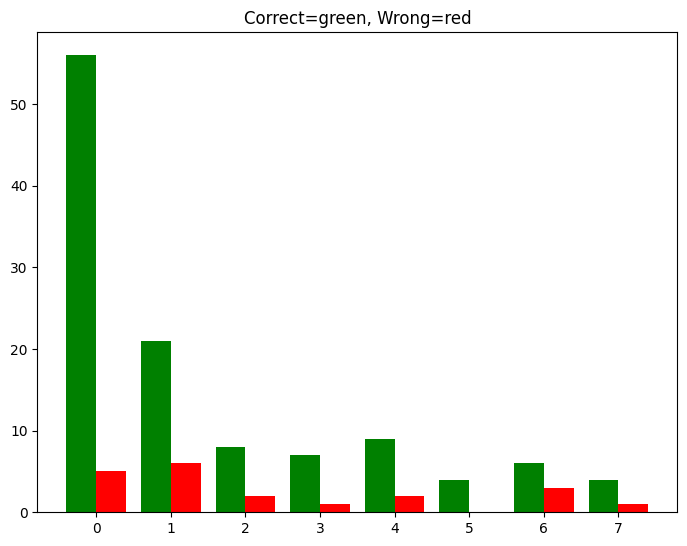

In [ ]:
class_labels= np.array([0., 1., 2., 3., 4., 5., 6., 7.])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1], title='Correct=green, Wrong=red')
ax.bar(class_labels - 0.2, correct, width=0.4, color='g')
ax.bar(class_labels + 0.2, wrong, width=0.4, color='r')
plt.show()